# -----------------------------------------------

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from urllib.request import urlretrieve
import unidecode
import numpy as np
import random
import sys
import re, cgi
import glob
import cv2

Using TensorFlow backend.


In [2]:
from time import time
from keras.callbacks import TensorBoard

In [3]:
import os
# Defining the directory path for the training set, validation set and test set 
# for all the chosen 3 categories
base_dir = 'LSTMimages'

In [4]:
image_folders = os.listdir(base_dir)

In [5]:
image_names = []
for folder in image_folders:
    image_loc = os.path.join(base_dir, folder)
    for s in os.listdir(image_loc):
        image_names.append(folder +'\\'+ s)

In [6]:
from sklearn.utils import shuffle

filenames_shuffled = shuffle(image_names)

In [7]:
filenames_shuffled_numpy = np.array(filenames_shuffled)

In [8]:
from sklearn.model_selection import train_test_split
X_train_filenames, X_test_filenames = train_test_split(
    filenames_shuffled_numpy, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (55196,)

print(X_test_filenames.shape)   # (13799,)

(1025,)
(257,)


In [9]:
train_width = 0
test_width = 0
maxlen = 100
step = 2
for i in X_train_filenames:
    train_width += (cv2.imread('c:/NHF/LSTMimages/' + str(i), cv2.IMREAD_UNCHANGED).shape[1] - maxlen)/step
for i in X_test_filenames:
    test_width += (cv2.imread('c:/NHF/LSTMimages/' + str(i), cv2.IMREAD_UNCHANGED).shape[1] - maxlen)/step

In [10]:
test_width

1191847.5

In [11]:
import keras
class My_Custom_Generator(keras.utils.Sequence) :
  
    def __init__(self, image_filenames, batch_size, maxlen, step, channels, width) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.channels = channels
        self.step = step
        self.width = width
        self.curr_img_idx = 0
        self.curr_img = cv2.imread('c:/NHF/LSTMimages/' + str(self.image_filenames[0]), cv2.IMREAD_UNCHANGED)/255.0
        self.img_height, self.img_width = self.curr_img.shape
        self.curr_window = 0
    
    def __len__(self) :
        #return (np.ceil((len(self.image_filenames) * (self.img_width - self.maxlen)/self.step) / float(self.batch_size))).astype(np.int)
        return (np.ceil(self.width / float(self.batch_size))).astype(np.int)
  
    def __getitem__(self, idx) :
        batch_x = []
        batch_y = []
        #print(idx, "th batch")
        for b in range(0,self.batch_size):
            if(self.channels == 1):
                batch_x.append(self.curr_img[:,self.curr_window:self.curr_window+self.maxlen])
                batch_y.append(self.curr_img[:,self.curr_window + self.maxlen])
            else:
                batch_x.append(self.curr_img[:,self.curr_window:self.curr_window+self.maxlen,:])
                batch_y.append(self.curr_img[:,self.curr_window + self.maxlen,:])
            self.curr_window += self.step
            
            if(self.curr_window >= self.img_width -self.maxlen):
                self.curr_img_idx += 1
                if(self.curr_img_idx >= X_train_filenames.shape[0]):
                    self.curr_img_idx = 0
                self.curr_img = cv2.imread('c:/NHF/LSTMimages/' + str(self.image_filenames[self.curr_img_idx]), cv2.IMREAD_UNCHANGED)/255.0
                self.img_height, self.img_width = self.curr_img.shape
                print(self.img_width)
                self.curr_window = 0
                #print("New image idx: ",  self.curr_img_idx)
                #print("b: ", b)
        batch_x = np.array(batch_x).reshape((self.batch_size, self.maxlen, self.img_height*self.channels))
        batch_y = np.array(batch_y).reshape((self.batch_size, self.img_height*self.channels))
        #print("Window: ", self.curr_window)
        #print("X.shape: ", batch_x.shape)
        #print("Y.shape: ", batch_y.shape)
        return batch_x, batch_y
    

In [12]:
batch_size = 64
maxlen = 150
step = 3
img_height = 88
channels = 1
num_trset = len(X_train_filenames)
num_testset = len(X_test_filenames)
my_training_batch_generator = My_Custom_Generator(X_train_filenames, batch_size, maxlen, 2, channels, train_width)
my_validation_batch_generator = My_Custom_Generator(X_test_filenames, 1, maxlen, 2, channels, test_width)

In [13]:
valid_data = []     # store all the generated data batches
valid_labels = []   # store all the generated label batches
max_iter = X_test_filenames.shape[0]  # maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
print(max_iter)
i = 0
for d, l in my_validation_batch_generator:
    #print(np.array(d).shape)
    valid_data.append(d)
    valid_labels.append(l)
    i += 1
    if i == max_iter:
        break

257


In [14]:
valid_data = np.array(valid_data).reshape(max_iter, maxlen, img_height*channels)
valid_labels = np.array(valid_labels).reshape(max_iter, img_height*channels)

In [15]:
valid_labels.shape

(257, 88)

In [16]:
from keras.callbacks import EarlyStopping
patience=5
early_stopping = EarlyStopping(patience=patience, verbose=1)
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = 'LSTM_bw_cl_150.hdf5', save_best_only=True, verbose=1)
logdir = "./logs/{}".format(time())
if(os.path.exists(logdir) == False):
    os.makedirs(logdir)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq = 1, write_grads=True, 
                          write_graph=True, write_images = True, update_freq='batch')

In [17]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [19]:
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
def custom_sigmoid(x):
    return K.sigmoid(x) * 255

get_custom_objects().update({'custom_sigmoid': Activation(custom_sigmoid)})





In [18]:
from keras import backend as K
import tensorflow as tf
alpha = 0.8
beta = 0.2
def customLoss(y_true, y_pred):
    loss = 0
    print(y_true.shape)
    for i in range(0,batch_size):
        #y_nn_idx = np.where(y_true[:,i] > 0)
        #y_null_idx = np.where(y_true[:,i] == 0)
        y_nn_idx = tf.where(tf.greater(y_true[:,i],0))
        y_null_idx = tf.where(tf.equal(y_true[:,i],0))
        loss += alpha*K.sum(K.square(y_pred[y_nn_idx,i] - y_true[y_nn_idx,i])) +  beta*K.sum(K.square(y_pred[y_null_idx,i] - y_true[y_null_idx,i]))
        #print(y_pred[y_nn_idx,i])
    return loss / y_true.shape[1]

In [19]:
#Lp norma a kimeneten
#tobb oszlopot prediktalni, predikciok alapjan is tanitani (seqtoseq LSTM)
#szabalyozasi kriteriumok merlegelese
#attention-t felhasznalni
alpha = 0.8
beta = 0.2
def customLoss2(y_true, y_pred):
    loss = 0
    loss = K.mean(alpha*K.sum(K.square(y_pred - y_true)*y_true) +  beta*K.sum(K.square(y_pred))*(1 - y_true))
    #print(y_pred[y_nn_idx,i])
    return loss

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, img_height*channels)))
model.add(Dense(88*channels))
model.add(Activation('sigmoid'))
#model.add(Activation(custom_sigmoid, name='SpecialActivation'))

model.compile(loss=customLoss2, optimizer='adam')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               111104    
_________________________________________________________________
dense_1 (Dense)              (None, 88)                11352     
_________________________________________________________________
activation_1 (Activation)    (None, 88)                0         
Total params: 122,456
Trainable params: 122,456
Non-trainable params: 0
_________________________________________________________________


In [21]:
net_history = model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(train_width // batch_size),
                   epochs = 15,
                   verbose = 1,
                   validation_data = (valid_data, valid_labels),
                   #validation_steps = int((num_testset*(200 - maxlen)/step) // batch_size),
                   callbacks=[early_stopping,checkpoint])


Epoch 1/15
76960/76960 [==============================] - 10862s 141ms/step - loss: 67.7109 - val_loss: 78.6986

Epoch 00001: val_loss improved from inf to 78.69856, saving model to LSTM_bw_cl_150.hdf5
Epoch 2/15
76960/76960 [==============================] - 11109s 144ms/step - loss: 66.2474 - val_loss: 80.9804

Epoch 00002: val_loss did not improve from 78.69856
Epoch 3/15
76960/76960 [==============================] - 11181s 145ms/step - loss: 62.1329 - val_loss: 73.5066

Epoch 00003: val_loss improved from 78.69856 to 73.50664, saving model to LSTM_bw_cl_150.hdf5
Epoch 4/15
76960/76960 [==============================] - 11266s 146ms/step - loss: 52.8675 - val_loss: 56.8496

Epoch 00004: val_loss improved from 73.50664 to 56.84959, saving model to LSTM_bw_cl_150.hdf5
Epoch 5/15
76960/76960 [==============================] - 11361s 148ms/step - loss: 39.6264 - val_loss: 36.4086

Epoch 00005: val_loss improved from 56.84959 to 36.40857, saving model to LSTM_bw_cl_150.hdf5
Epoch 6/15


KeyboardInterrupt: 

In [92]:
start_img = random.randint(0,X_train_filenames.shape[0])
import matplotlib.pyplot as plt

----- Generating with seed:


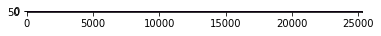

In [93]:
generated = []
img = cv2.imread('c:/NHF/LSTMimages/' + str(X_train_filenames[start_img]), cv2.IMREAD_UNCHANGED)/255.0 # kiválasztunk egy kezdeti szöveget, amiből kiindulunk, a neuronháló ezt fogja folytatni
print('----- Generating with seed:')
plt.imshow(img)
for w in range(0,maxlen):
    generated.append(img[:,w])

In [94]:
generated = np.array(generated).reshape((1,maxlen,88*1))

In [66]:
from keras.models import load_model
model = load_model('LSTM_bw255_cl.hdf5')

ValueError: Unknown loss function:customLoss2

In [95]:
for i in range(100): # legenerálunk 400 karaktert egymás után
    preds = model.predict(generated[:,i:i+maxlen], verbose=0)[0] # forward pass
    preds = preds.reshape((1,1,88*1))
    generated = np.concatenate((generated, preds), axis = 1)
print()

In [96]:
generated.shape

(1, 250, 88)

In [97]:
gen_img = generated.reshape((250,88))

In [98]:
gen_img = np.swapaxes(gen_img, 0, 1)

In [99]:
#gen_norm = np.minimum(gen_img*10**2, np.ones(shape = gen_img.shape))
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [100]:
gen_img255 = gen_img*255
gen_img_i = gen_img255.astype(np.uint8)

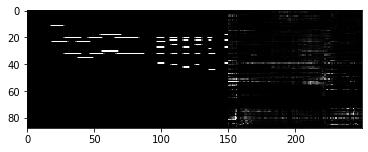

In [101]:
plt.imshow(gen_img_i, cmap='gray')

In [102]:
from PIL import Image
image = Image.fromarray(gen_img_i, mode = 'L')
image.save('C:/NHF/gen8.png')

In [37]:
gen_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)